## Contexte de l'exercice
Cette étude a pour objectif de mettre en pratique un algorithme de **partitionnement non supervisé** sur des données issues de deux sources différentes.

Il s'agit de partitionner les départements de métropole en fonction de la quantité de glyphosate vendue sur ces départements d'une part, et de la mesure des taux de glyphosate dans l'eau d'autre part. 

### Limites
Cet exercice a un objectif **technique et méthodologique**. 
Même s'il est basé sur des données réelles, un certain nombre de limites sont identifiées : 
* L'obtention du "score de mesure de glyphosate" décrit plus bas mériterait d'être perfectionné. Il est basé sur une moyenne des scores par stations, ces scores étant eux-mêmes les moyennes des mesures sur l'année. Les scores des stations pourraient être pondérées en fonction de leurs caractéristiques ou de leur localisation. Par ailleurs, ne sont pas pris en compte : les caractéristiques des cours d'eau dans lesquels sont effectuées les mesures, le taux de couverture des stations de mesure par départements, les variations saisonnières, etc
* L'exercice ne porte que les données de glyphosate. Il serait plus cohérent d'inclure l'ensemble des PPP.
* Les ventes de PPP sur un département ne correspondent pas à l'utilisation de ces PPP sur ce même département. En effet, des consommateurs peuvent s'approvisionner dans un département voisin, ou stocker les produits pour une utilisation différée, par exemple.
* Les données de mesure issues de Naïades sont manquantes pour certains départements (Seine Saint Denis, Haut Rhin, Bas Rhin ...)

### Liens de téléchargement des données : 
* Données sur les [analyses de glyphosate](http://www.naiades.eaufrance.fr/acces-donnees#/physicochimie/resultats?debut=18-03-2018&fin=18-03-2021&parametres=1506) > Analyses.CSV
* Données sur l'[hydrobiologie](http://www.naiades.eaufrance.fr/france-entiere#/)  > resultat.CSV
* Données sur les [ventes de PPP](http://www.data.eaufrance.fr/jdd/bd45f801-45f7-4f8c-b128-a1af3ea2aa3e) > BNVD_2020_VENTE_SUBSTANCE_2019.csv
* Contour des [départements](https://www.data.gouv.fr/fr/datasets/carte-des-departements-2-1/) > contour-des-departements.geojson

### Import des librairies

In [290]:
import pandas as pd
import geopandas as gpd

import sklearn.metrics as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import numpy as np

### Paramétrage

In [291]:
cheminAnalyses = 'C:\\Users\\gregoire.etot\\Desktop\\dev\\glypho\\Analyses.CSV'
cheminStations = 'C:\\Users\\gregoire.etot\\Desktop\\dev\\glypho\\HB_2020\\Stations.CSV'
cheminVentesGlyphosate = 'C:\\Users\\gregoire.etot\\Desktop\\dev\\glypho\\BNVD_2020_VENTE_2019\\BNVD_2020_VENTE_SUBSTANCE_2019.csv'
cheminFondDept = 'C:\\Users\\gregoire.etot\\Desktop\\dev\\glypho\\contour-des-departements.geojson'
uniteMesure = 133 # µg/L
dateDebutAnalyses = '2019-01-01'
dateFinAnalyses = '2020-01-01'
tauxMaxGlyphosate = 200
anneVenteGlyphosate = 2019

### Lecture des données de Naïades sur les mesures de glyphosate et sur les stations associées, premier nettoyage
Création d'un score "mesure de glyphosate dans l'eau" par département, basé sur la moyenne des taux de glyphosate mesurés par chaque station du département (eux-mêmes étant la moyenne des taux mesurés pour cette station sur l'année)

In [292]:
# lecture des csv
# glyphoana ne contient que les données sur le glyphosate
glyphoana = pd.read_csv(cheminAnalyses, sep=';')
stations = pd.read_csv(cheminStations, sep=';')

# suppression des valeurs à ne pas prendre en compte
glyphoana = glyphoana[glyphoana["CdQualAna"] == 1] # données validées ("correctes")
glyphoana = glyphoana[glyphoana["CdUniteMesure"] == uniteMesure] # même unité de mesure 
glyphoana = glyphoana[(glyphoana['DatePrel'] >= dateDebutAnalyses) & (glyphoana['DatePrel'] < dateFinAnalyses)]
glyphoana = glyphoana[glyphoana["RsAna"] < tauxMaxGlyphosate] # valeurs abberrantes

#merge avec la table des stations pour récupérer le département
glyphoana = glyphoana.merge(stations, on=['CdStationMesureEauxSurface'])

# on attribue à chaque station la moyenne de ses mesures, pour ne pas que le nombre de mesures ait une incidence
glyphoana_perdep = glyphoana.groupby(['CdStationMesureEauxSurface', 'LbDepartement']).RsAna.mean()

# on groupe ensuite par départements
# on utilise le libellé et non le code car pour les ventes, on n'a que le libellé
glyphoana_perdep = glyphoana.groupby('LbDepartement').RsAna.mean()

glyphoana_perdep.head()

LbDepartement
Ain                        0.068679
Aisne                      0.124810
Allier                     0.047609
Alpes-Maritimes            0.045946
Alpes-de-Haute-Provence    0.030000
Name: RsAna, dtype: float64

### Lecture des données de vente 2019

In [293]:
glyphoventes = pd.read_csv(cheminVentesGlyphosate, sep=';')
glyphoventes = glyphoventes[glyphoventes["substance"] == "glyphosate"]
glyphoventes = glyphoventes[glyphoventes["annee"] == anneVenteGlyphosate]
glyphoventes_perdep = glyphoventes.groupby('departement').quantite_substance.sum()
glyphoventes_perdep.head()

departement
AIN                         47403.6736
AISNE                      111187.7173
ALLIER                      82343.3890
ALPES-DE-HAUTE-PROVENCE     11717.8500
ALPES-MARITIMES              4036.5243
Name: quantite_substance, dtype: float64

### Croisement des données de vente et du score "mesure de glyphosate dans l'eau"

,RsAna,quantite_substance
RsAna,1.000000,0.337808
quantite_substance,0.337808,1.000000


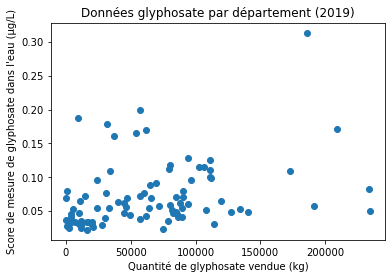

In [294]:
# on fait correspondre les indexes (différents dans les deux tableaux : majuscules et accents)
glyphoana_perdep.index = glyphoana_perdep.index.str.lower()
glyphoventes_perdep.index = glyphoventes_perdep.index.str.lower()

mapping = { 'ô':'o', 'é':'e', 'è':'e', 'à':'a'}
for k, v in mapping.items():
    glyphoana_perdep.index = glyphoana_perdep.index.str.replace(k,v)
    glyphoventes_perdep.index = glyphoventes_perdep.index.str.replace(k,v)
    
glyphoana_perdep.index.name = "departement"

# jointure
glyphodf = pd.concat([glyphoana_perdep, glyphoventes_perdep], axis=1, join="inner")

plt.title('Données glyphosate par département (2019)')
plt.xlabel("Quantité de glyphosate vendue (kg)")
plt.ylabel("Score de mesure de glyphosate dans l'eau (µg/L)")
plt.scatter(glyphodf.quantite_substance, glyphodf.RsAna)

# Coefficient de corrélation linéaire, donné à titre indicatir 
# (corrélation forte si valeur absolue >0,5)
glyphodf.corr(method ='pearson')

### Variables centrées réduites pour préparation k-means

In [295]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(glyphodf)
scaled_df = pd.DataFrame(scaled_df, columns=["quantite_substance", "glyphodf.RsAna"])
scaled_df.head()

,quantite_substance,glyphodf.RsAna
0,-0.052302,-0.307502
1,1.114985,0.885110
2,-0.490460,0.345789
3,-0.525038,-1.118367
4,-0.856641,-0.974744


### Partitionnement, à l'aide de la méthode des k-means

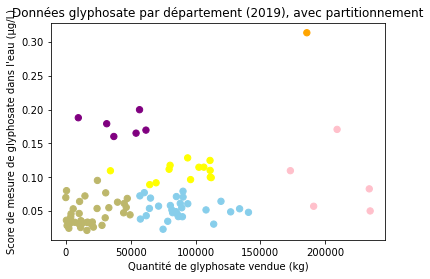

In [296]:
# exécution de l'algo kmeans
model=KMeans(n_clusters=6, init = 'k-means++', random_state = 5,  max_iter=500)
model.fit(scaled_df)

# représentation graphique
colormap = np.array(['skyblue', 'yellow', 'darkkhaki', 'orange', 'purple', 'pink'])
plt.title('Données glyphosate par département (2019), avec partitionnement')
plt.xlabel("Quantité de glyphosate vendue (kg)")
plt.ylabel("Score de mesure de glyphosate dans l'eau (µg/L)")
plt.scatter(glyphodf.quantite_substance, glyphodf.RsAna, c=colormap[model.labels_],s=40)

### Représentation cartographique : préparation des variables

In [297]:
# reinit index pour permettre la concaténation
glyphodf.reset_index(level=0, inplace=True)
# on met le score dans le dataframe
glyphodf = pd.concat((glyphodf, pd.Series(model.labels_).rename('colorlabel')), axis=1)
# on remet les departement comme indexes
glyphodf.set_index('departement', inplace=True)

departements = gpd.read_file(cheminFondDept)

# on change l'index du geodf par le nom minuscule et sans accent, 
# pour permettre la concaténation et ainsi récupérer le score
departements.set_index('nom', inplace=True)
departements.index = departements.index.str.lower()
for k, v in mapping.items():
    departements.index = departements.index.str.replace(k,v)
    
departements = pd.concat((departements, glyphodf), axis=1)
departements = departements.dropna()

# couleur à partir du score et du tableau de couleurs
departements['colorlabel'] = departements['colorlabel'].apply(lambda x: colormap[int(x)])

### Représentation cartographique 

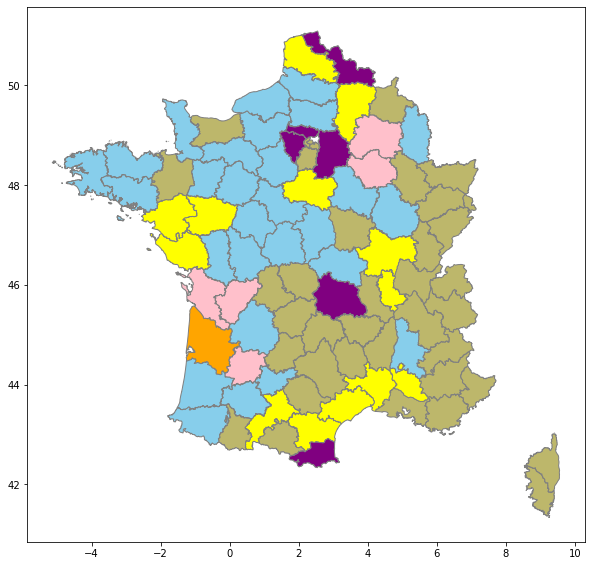

In [298]:
ax = departements.plot(figsize=(10, 10), color=departements.colorlabel, edgecolor='gray')